Mounted at /content/drive
11490434/11490434 [==============================] - 0s 0us/step
Edge server 1 has 10 unique labels: [0 1 2 3 4 5 6 7 8 9]
Count of each label: {0: 600, 1: 600, 2: 600, 3: 600, 4: 600, 5: 600, 6: 600, 7: 600, 8: 600, 9: 600}
Edge server 2 has 10 unique labels: [0 1 2 3 4 5 6 7 8 9]
Count of each label: {0: 600, 1: 600, 2: 600, 3: 600, 4: 600, 5: 600, 6: 600, 7: 600, 8: 600, 9: 600}
Edge server 3 has 10 unique labels: [0 1 2 3 4 5 6 7 8 9]
Count of each label: {0: 600, 1: 600, 2: 600, 3: 600, 4: 600, 5: 600, 6: 600, 7: 600, 8: 600, 9: 600}
Edge server 4 has 10 unique labels: [0 1 2 3 4 5 6 7 8 9]
Count of each label: {0: 600, 1: 600, 2: 600, 3: 600, 4: 600, 5: 600, 6: 600, 7: 600, 8: 600, 9: 600}
Edge server 5 has 10 unique labels: [0 1 2 3 4 5 6 7 8 9]
Count of each label: {0: 600, 1: 600, 2: 600, 3: 600, 4: 600, 5: 600, 6: 600, 7: 600, 8: 600, 9: 600}
After Edge Aggregation 1 in round 1: Test Loss = 0.1432694047689438, Test Accuracy = 0.957099974155426
After 

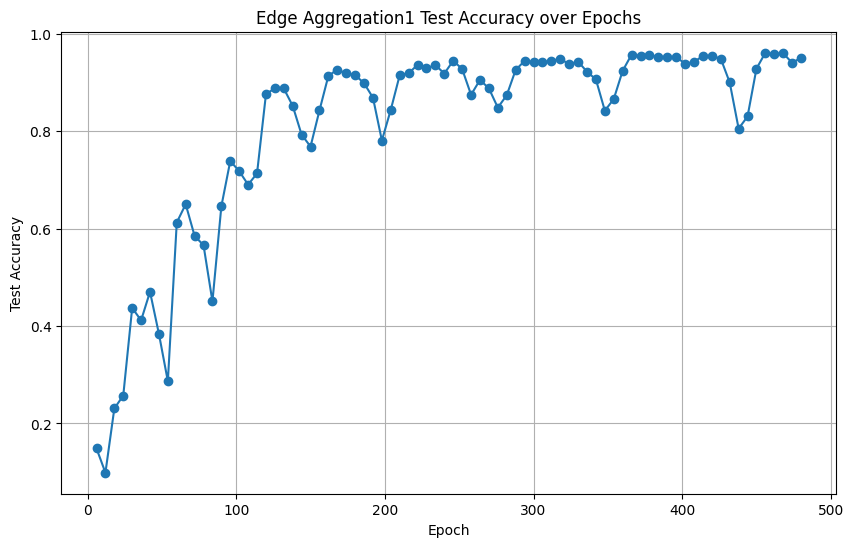

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from google.colab import drive
import os

# 구글 드라이브 마운트
drive.mount('/content/drive')

# MNIST 데이터셋 불러오기
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 0~255의 픽셀값을 0~1 사이 실수로 정규화
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# CNN을 위해 입력 데이터 형태 변경
x_train = x_train.reshape((-1, 28, 28, 1))
x_test = x_test.reshape((-1, 28, 28, 1))

# MNIST 손글씨 숫자를 분류하는 CNN 모델 생성
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(32, (5,5), activation='relu', kernel_initializer='he_uniform'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (5,5), activation='relu', kernel_initializer='he_uniform'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_initializer='he_uniform'),
    tf.keras.layers.Dense(10, activation='softmax', kernel_initializer='he_uniform')
])

# 가중치 불러오기 시도
try:
    model.load_weights('/content/drive/MyDrive/model_weights5.h5')
except:
    print("가중치 파일을 불러오지 못했습니다.")

num_clients = 50  # Set the number of clients
num_edges = 5  # Set the number of edges
clients_per_edge = num_clients // num_edges  # Calculate the number of clients per edge
B = 20

num_labels = 10
total_sample = int(600)  # Change total_sample to 600

client_indices_list = []
label_indices = [[] for _ in range(num_labels)]

for i in range(len(y_train)):
    label = y_train[i]
    label_indices[label].append(i)

for i in range(num_edges):
    for j in range(clients_per_edge):  # Use clients_per_edge instead of 10
        selected_label = (i * clients_per_edge + j) % num_labels
        label_samples = label_indices[selected_label]
        selected_samples = np.random.choice(label_samples, total_sample, replace=False)
        client_indices_list.append(np.array(selected_samples))

# After data partitioning
for edge_idx in range(num_edges):
    edge_labels = []
    for client_idx in range(edge_idx * (num_clients // num_edges), (edge_idx+1) * (num_clients // num_edges)):
        edge_labels.extend(y_train[client_indices_list[client_idx]])
    unique_labels, label_counts = np.unique(edge_labels, return_counts=True)
    print(f"Edge server {edge_idx+1} has {len(unique_labels)} unique labels: {unique_labels}")
    print(f"Count of each label: {dict(zip(unique_labels, label_counts))}")

edge_models = [model.get_weights()] * num_edges

def client_update(client_x, client_y, B, E):
    # Add momentum to the SGD optimizer
    sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.01 * 0.995 ** epoch)

    model.compile(optimizer=sgd,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(client_x,
                        client_y,
                        batch_size=B,
                        epochs=E,
                        callbacks=[lr_schedule],
                        shuffle=True,
                        verbose=0)

    return model.get_weights()  # Return the updated weights

num_rounds = 20
E = 6

w = model.get_weights()

rounds_list_edge1 = []  # Edge Aggregation1의 에폭 수를 저장할 리스트
test_acc_list_edge1 = []  # Edge Aggregation1의 테스트 정확도를 저장할 리스트

k1, k2 = 1, 10
local_update_counter = 0
edge_update_counter = 0

for t in range(num_rounds):
    test_acc = 0
    edge_updates = [None] * num_edges
    for edge_idx in range(num_edges):
        client_updates = []
        client_sizes = []
        for client_idx in range(edge_idx * 10, (edge_idx + 1) * 10):  # Each edge has 10 clients
            model.set_weights(edge_models[edge_idx])

            client_x = x_train[client_indices_list[client_idx]]
            client_y = y_train[client_indices_list[client_idx]]

            updated_weights = client_update(client_x, client_y, B, E)

            client_updates.append(updated_weights)
            client_sizes.append(len(client_x))

        # Aggregate the updates from the clients of this edge using weighted average
        total_size = sum(client_sizes)
        weights = [size / total_size for size in client_sizes]
        edge_updates[edge_idx] = [np.average([update[i] for update in client_updates], axis=0, weights=weights) for i in range(len(w))]

        # Set the edge model weights to the edge updates
        edge_models[edge_idx] = edge_updates[edge_idx]

    local_update_counter += 1

    if local_update_counter % k1 == 0:
        # Evaluate the model with the test dataset for each edge
        for edge_idx in range(num_edges):
            model.set_weights(edge_models[edge_idx])
            test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
            print(f"After Edge Aggregation {edge_idx+1} in round {t+1}: Test Loss = {test_loss}, Test Accuracy = {test_acc}")

            # edge_idx가 0인 경우, 즉 Edge Aggregation1의 경우에만 테스트 정확도와 에폭 수를 저장합니다.
            if edge_idx == 0:
                test_acc_list_edge1.append(test_acc)
                rounds_list_edge1.append((t + 1) * E)  # 에폭 수 계산

        edge_update_counter += 1

        if edge_update_counter % k2 == 0 and None not in edge_updates:
            # Aggregate the updates from all the edges
            averaged_weights = [np.mean([update[i] for update in edge_updates if update is not None], axis=0) for i in range(len(w))]

            model.set_weights(averaged_weights)

            test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

            print(f"After Cloud Aggregation {t+1}: Test Loss = {test_loss}, Test Accuracy = {test_acc}")

# 모델 가중치 저장
model.save_weights('/content/drive/MyDrive/model_weights5.h5')

# 이전 실행 결과를 저장하는 파일의 경로
history_file = '/content/drive/MyDrive/history3.npy'

# 이전 실행 결과를 불러옴
if os.path.exists(history_file):
    history = np.load(history_file, allow_pickle=True).item()
else:
    history = {'accuracy_edge1': []}

# 'rounds_edge1' 키가 없는 경우 추가
if 'rounds_edge1' not in history:
    history['rounds_edge1'] = []

# 이전 실행에서의 마지막 에폭 수
last_epoch = history['rounds_edge1'][-1] if history['rounds_edge1'] else 0

# 이전 실행 결과에 새로운 결과를 추가
history['rounds_edge1'].extend([epoch + last_epoch for epoch in rounds_list_edge1])  # 에폭 수 업데이트
history['accuracy_edge1'].extend(test_acc_list_edge1)

# 결과를 파일에 저장
np.save(history_file, history)

# Edge Aggregation1의 테스트 정확도를 그래프로 그립니다.
plt.figure(figsize=(10, 6))
plt.plot(history['rounds_edge1'], history['accuracy_edge1'], marker='o')
plt.title("Edge Aggregation1 Test Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.show()